In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

bengin_path = './The IQ-OTHNCCD lung cancer dataset/Bengin cases'
malignant_path = './The IQ-OTHNCCD lung cancer dataset/Malignant cases'
normal_path = './The IQ-OTHNCCD lung cancer dataset/Normal cases'

print("Current Working Directory:", os.getcwd())

for path in [bengin_path, malignant_path, normal_path]:
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
    else:
        print(f"Directory found: {path}")

        img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
        path_list = [bengin_path, malignant_path, normal_path]

        img_path = []
        class_labels = []
        for i, dir_list in enumerate(path_list):

            name_img = os.listdir(dir_list)
            for name_file in name_img:
                img = os.path.join(dir_list,name_file)
                img_path.append(img)
                class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()


Current Working Directory: /Users/manitatamang/Desktop/dissertation/notebook
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Bengin cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Malignant cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Normal cases


,img_path,label
0,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
1,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
2,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
3,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
4,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases


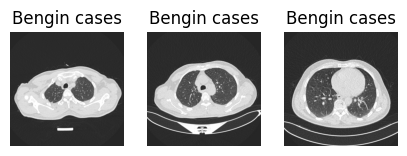

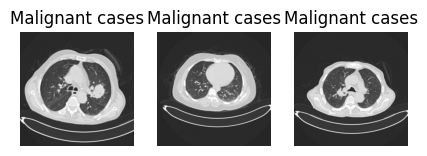

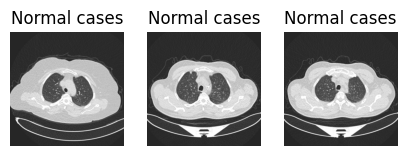

In [5]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (5,5))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [6]:
countData = df["label"].value_counts().reset_index()
countData.columns = ['label', 'count']
print(countData)
fig = px.histogram(data_frame = countData, x = "label", y = "count")
fig.show()

             label  count
0  Malignant cases    561
1     Normal cases    416
2     Bengin cases    120


In [26]:
import nbformat
print(nbformat.__version__)

5.10.4


In [38]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.19.0
3.9.1


In [7]:
sizes = []
resolutions = []
color_distrubtions = []

for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes.append(size)
    resolution = img.shape[:2]
    resolutions.append(resolution)
    mean_color_distrubtions = np.bincount(img.flatten(),minlength=256)
    color_distrubtions.append(mean_color_distrubtions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
mean_color_distrubtions = np.array(color_distrubtions)

In [8]:
sizes_MB = []
for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins=50, title="Distrubtion of image sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                  yaxis_title = "Number of Images",
                  showlegend = False,
                  bargap = 0.1,
                  bargroupgap = 0.1)
fig.update_traces(marker=dict(color="green"))
fig.show()

In [6]:
fig = px.scatter(x = resolutions[:,0], y=resolutions[:,1], title="Distribution of Image resolution")
fig.update_layout(
    xaxis_title="Width (Pixel)",
    yaxis_title="Height (Pixel)",
    showlegend = False,
    hovermode="closest"
)
fig.update_traces(marker=dict(color="red"))
fig.show()

In [9]:
mean_color_distrubtions = np.mean(color_distrubtions, axis = 0)
fig = go.Figure(
    go.Bar(x=np.arange(256), y=mean_color_distrubtions, name="Mean Color Distrubtions")
)
fig.update_layout(
    title="Mean Color Distrubtion",
    xaxis_title="Color Values",
    yaxis_title="Number of Pixel"
)
fig.show()

Train Test Split

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")


Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


Denoise Image Using Median Blur

In [12]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32
TRAIN_DATAGEN = ImageDataGenerator(rescale=1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                   rotation_rage = 30,
                                   width_shift_range = 0.1, height_shift_range = 0.2,
                                   shear_range = 0.1, zoom_range = 0.2,
                                   horizontal_flip = True)
TEST_DATAGEN = ImageDataGenerator(rescale=1./255.)
train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = 'rgb', class_mode = "categorical",
    shuffle = True
)

val